# ------------------------------------------------------------
# Binary Classification
# ------------------------------------------------------------

## Read

In [3]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb
import pandas as pd
import tkinter as tk
from tkinter import filedialog

## Select the input file
print('Select the input file\n')
root = tk.Tk()
root.withdraw()
file = filedialog.askopenfilename(filetypes =(("Export Call - CS", "*.xlsx"),("All Files","*.*")))

## Read the file
print('Reading...\n')
export = pd.read_excel(file, index_col='Date Of Test', header=0, decimal=",")
export.index = pd.to_datetime(export.index)

Select the input file

Reading...



### Binarize MOS and get a "ModelFrame" object

In [2]:
from sklearn.preprocessing import LabelEncoder
import pandas_ml as pdml
import matplotlib.pyplot as plt
import numpy as np

df = export.copy()

## Select only these columns
df = df.filter(items=['Signal (dBm)','Speed (m/s)','Distance from site (m)',
                      'Call Test Duration (s)','Call Test Result','Call Test Technology',
                      'MANUFACTURER', 'Estimated MoS'])
# binarize MOS
df.loc[df['Estimated MoS']<=2.7,'Estimated MoS'] = 0.0
df.loc[df['Estimated MoS']>2.7,'Estimated MoS'] = 1.0

#Hystogram of MOS
print(df['Estimated MoS'].value_counts())
        
#Label encoding
df[['Call Test Result',
    'Call Test Technology',
    'MANUFACTURER',
    'Estimated MoS']] = df[['Call Test Result','Call Test Technology','MANUFACTURER',
                            'Estimated MoS']].apply(LabelEncoder().fit_transform)

#Drop NaN
df.dropna(inplace=True)

print('\nRows and columns:')
print(df.shape)

df = pdml.ModelFrame(df, target='Estimated MoS')

1.0    54423
0.0    51405
Name: Estimated MoS, dtype: int64

Rows and columns:
(95466, 8)


## Train/Test split

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test = df.model_selection.train_test_split(random_state=0)
print('\nTrain rows: {0}'.format(X_train.shape[0]))
print('Test rows: {0}'.format(X_test.shape[0]))

print(df.shape)


Train rows: 71599
Test rows: 23867
(95466, 8)


## Grid Search CV

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

tuned_parameters = [{'max_depth': list(range(9,21)),
                    'max_features': list(range(2,8)),
                    'n_estimators': [10, 50, 100],
                    'bootstrap': [True, False]}]

bst = df.model_selection.GridSearchCV(
                        df.ensemble.RandomForestClassifier(random_state=0),
                        tuned_parameters, cv=3)

df.fit(bst)
bst.best_estimator_

#### 1) k-NN

Predicted correctly: 18777/23867
Accuracy (%): 78.6735


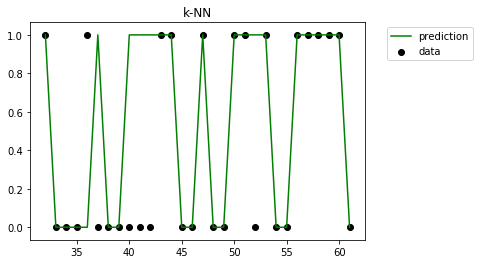

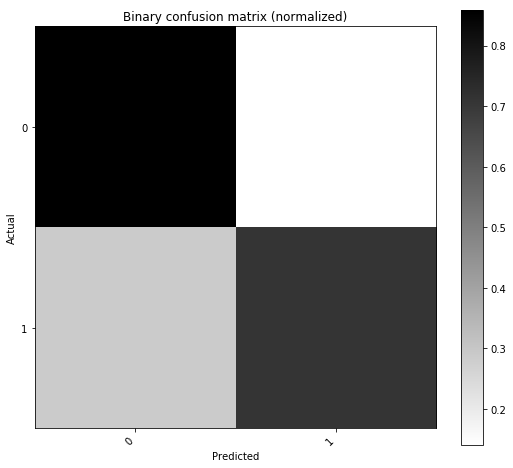

In [8]:
knn = df.neighbors.KNeighborsClassifier(n_neighbors=18)

X_train.fit(knn)
preds = X_test.predict(knn)

correct=0
for i in range(len(preds)):
    if(X_test.target.iloc[i]==preds.iloc[i]):
        correct += 1

acc = correct/len(preds)*100

print('Predicted correctly: {0}/{1}'.format(correct,len(preds)))
print('Accuracy (%): {0:.4f}'.format(acc))
#print('Error (%): {0:.4f}'.format(100-acc))

y_test = X_test.target            #actual labels
ax = np.arange(1,len(y_test)+1)   #X-axis index for plotting

plt.figure()
n_points = 30
start_point = 31
plt.scatter(ax[start_point:(start_point+n_points)], y_test[start_point:(start_point+n_points)], c='k', label='data')
plt.plot(ax[start_point:(start_point+n_points)], preds[start_point:(start_point+n_points)], c='g', label='prediction')
plt.axis('tight')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title("k-NN")
plt.show()

import matplotlib.pyplot as plt
from pandas_ml import ConfusionMatrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
%matplotlib inline

conf_matrix = ConfusionMatrix(y_test, preds)
conf_matrix.plot(normalized=True)

#### 2) Logistic Classifier

Predicted correctly: 18419/23867
Accuracy (%): 77.1735


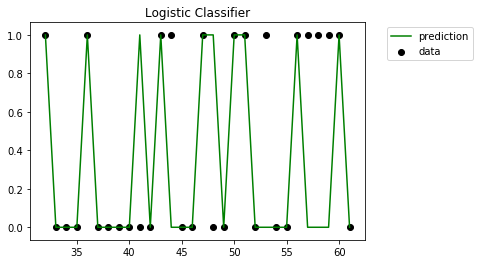

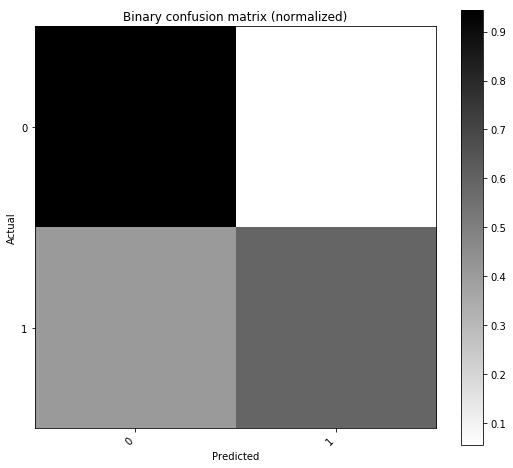

In [9]:
log = df.linear_model.LogisticRegression(fit_intercept=True, random_state=0)

X_train.fit(log)
preds = X_test.predict(log)

correct=0
for i in range(len(preds)):
    if(X_test.target.iloc[i]==preds.iloc[i]):
        correct += 1

acc = correct/len(preds)*100

print('Predicted correctly: {0}/{1}'.format(correct,len(preds)))
print('Accuracy (%): {0:.4f}'.format(acc))
#print('Error (%): {0:.4f}'.format(100-acc))

y_test = X_test.target            #actual labels
ax = np.arange(1,len(y_test)+1)   #X-axis index for plotting

plt.figure()
n_points = 30
start_point = 31
plt.scatter(ax[start_point:(start_point+n_points)], y_test[start_point:(start_point+n_points)], c='k', label='data')
plt.plot(ax[start_point:(start_point+n_points)], preds[start_point:(start_point+n_points)], c='g', label='prediction')
plt.axis('tight')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title("Logistic Classifier")
plt.show()

import matplotlib.pyplot as plt
from pandas_ml import ConfusionMatrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
%matplotlib inline

conf_matrix = ConfusionMatrix(y_test, preds)
conf_matrix.plot(normalized=True)

#### 3) SVM

Predicted correctly: 18481/23867
Accuracy (%): 77.4333


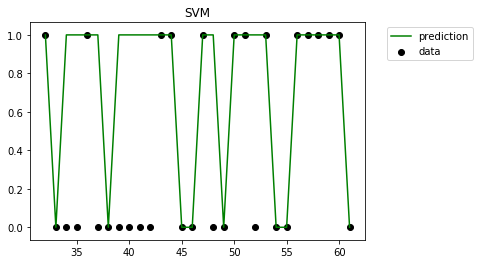

In [13]:
#Support Vector Machine with C=1, Radial Basis function as kernel
svc = df.svm.SVC(C=1.0, kernel='rbf', gamma='auto', random_state=0)

X_train.fit(svc)                #train the model with training set
preds = X_test.predict(svc)     #make predictions on test set

correct=0
for i in range(len(preds)):
    if(X_test.target.iloc[i]==preds.iloc[i]):
        correct += 1

acc = correct/len(preds)*100

print('Predicted correctly: {0}/{1}'.format(correct,len(preds)))
print('Accuracy (%): {0:.4f}'.format(acc))
#print('Error (%): {0:.4f}'.format(100-acc))

y_test = X_test.target            #actual labels
ax = np.arange(1,len(y_test)+1)   #X-axis index for plotting

plt.figure()
n_points = 30
start_point = 31
plt.scatter(ax[start_point:(start_point+n_points)], y_test[start_point:(start_point+n_points)], c='k', label='data')
plt.plot(ax[start_point:(start_point+n_points)], preds[start_point:(start_point+n_points)], c='g', label='prediction')
plt.axis('tight')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title("SVM")
plt.show()

import matplotlib.pyplot as plt
from pandas_ml import ConfusionMatrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
%matplotlib inline

conf_matrix = ConfusionMatrix(y_test, preds)

#### 4) Decision Tree

Predicted correctly: 18607/23867
Accuracy (%): 77.9612


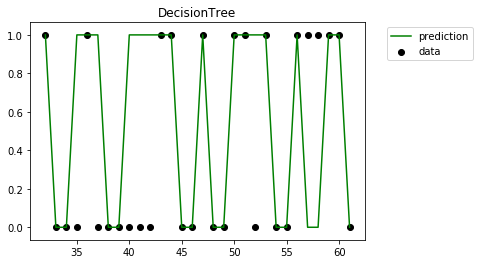

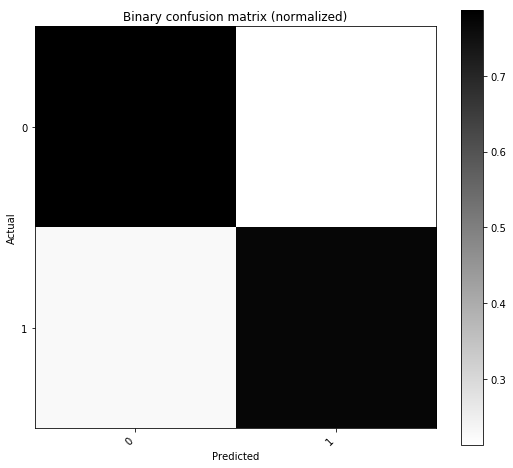

In [6]:
dt = df.tree.DecisionTreeClassifier(random_state=0)

X_train.fit(dt)
preds = X_test.predict(dt)

correct=0
for i in range(len(preds)):
    if(X_test.target.iloc[i]==preds.iloc[i]):
        correct += 1

acc = correct/len(preds)*100

print('Predicted correctly: {0}/{1}'.format(correct,len(preds)))
print('Accuracy (%): {0:.4f}'.format(acc))
#print('Error (%): {0:.4f}'.format(100-acc))

y_test = X_test.target            #actual labels
ax = np.arange(1,len(y_test)+1)   #X-axis index for plotting

plt.figure()
n_points = 30
start_point = 31
plt.scatter(ax[start_point:(start_point+n_points)], y_test[start_point:(start_point+n_points)], c='k', label='data')
plt.plot(ax[start_point:(start_point+n_points)], preds[start_point:(start_point+n_points)], c='g', label='prediction')
plt.axis('tight')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title("DecisionTree")
plt.show()

import matplotlib.pyplot as plt
from pandas_ml import ConfusionMatrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
%matplotlib inline

conf_matrix = ConfusionMatrix(y_test, preds)
conf_matrix.plot(normalized=True)

#### 5) Neural Network

Predicted correctly: 19012/23867
Accuracy (%): 79.6581


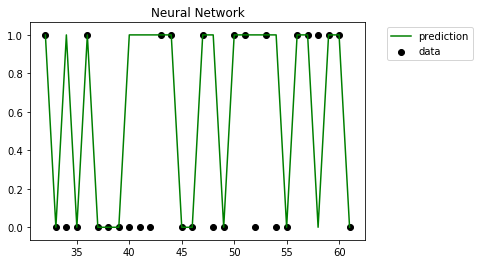

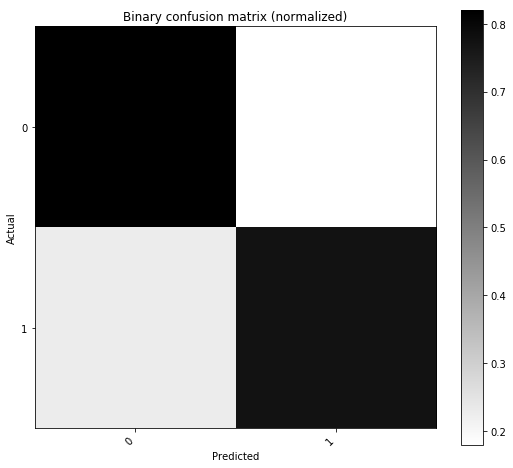

In [17]:
net = df.neural_network.MLPClassifier(activation = 'tanh',
                                      alpha = 0.0001,
                                      solver= 'adam',
                                      batch_size= 'auto',
                                      hidden_layer_sizes = [100,100,50,10],
                                      random_state = 0)

X_train.fit(net)
preds = X_test.predict(net)

correct=0
for i in range(len(preds)):
    if(X_test.target.iloc[i]==preds.iloc[i]):
        correct += 1

acc = correct/len(preds)*100

print('Predicted correctly: {0}/{1}'.format(correct,len(preds)))
print('Accuracy (%): {0:.4f}'.format(acc))
#print('Error (%): {0:.4f}'.format(100-acc))

y_test = X_test.target            #actual labels
ax = np.arange(1,len(y_test)+1)   #X-axis index for plotting

plt.figure()
n_points = 30
start_point = 31
plt.scatter(ax[start_point:(start_point+n_points)], y_test[start_point:(start_point+n_points)], c='k', label='data')
plt.plot(ax[start_point:(start_point+n_points)], preds[start_point:(start_point+n_points)], c='g', label='prediction')
plt.axis('tight')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title("Neural Network")
plt.show()

import matplotlib.pyplot as plt
from pandas_ml import ConfusionMatrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
%matplotlib inline

conf_matrix = ConfusionMatrix(y_test, preds)
conf_matrix.plot(normalized=True)

#### 6) Random Forest

Predicted correctly: 19872/23867
Accuracy (%): 83.2614


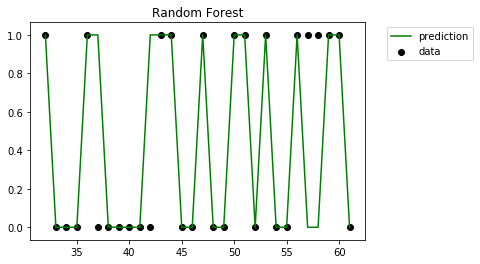

population: 23867
P: 11687
N: 12180
PositiveTest: 9964
NegativeTest: 13903
TP: 8828
TN: 11044
FP: 1136
FN: 2859
TPR: 0.755369213656
TNR: 0.906732348112
PPV: 0.885989562425
NPV: 0.794360929296
FPR: 0.0932676518883
FDR: 0.114010437575
FNR: 0.244630786344
ACC: 0.832614069636
F1_score: 0.815481963882
MCC: 0.671164006125
informedness: 0.662101561768
markedness: 0.680350491721
prevalence: 0.489671931956
LRP: 8.09894104079
LRN: 0.269793822679
DOR: 30.0190010296
FOR: 0.205639070704


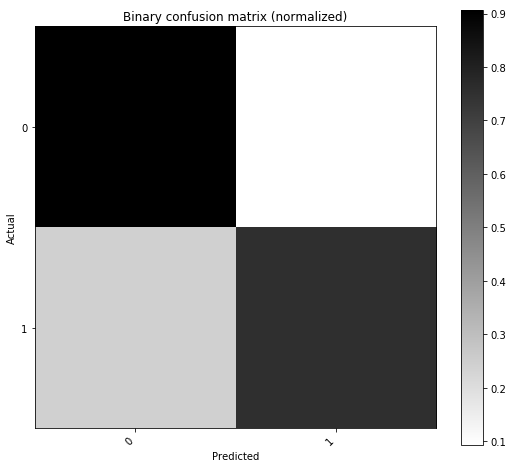

In [10]:
bst = df.ensemble.RandomForestClassifier(random_state=0, max_depth=9, n_estimators=100)

X_train.fit(bst)
preds = X_test.predict(bst)
#preds = bst.predict(X_test)

correct=0
for i in range(len(preds)):
    if(X_test.target.iloc[i]==preds.iloc[i]):
        correct += 1

acc = correct/len(preds)*100

print('Predicted correctly: {0}/{1}'.format(correct,len(preds)))
print('Accuracy (%): {0:.4f}'.format(acc))
#print('Error (%): {0:.4f}'.format(100-acc))

#X_test.metrics.confusion_matrix()
#
#import matplotlib.pyplot as plt
#%matplotlib inline

y_test = X_test.target            #actual labels
ax = np.arange(1,len(y_test)+1)   #X-axis index for plotting

plt.figure()
n_points = 30
start_point = 31
plt.scatter(ax[start_point:(start_point+n_points)], y_test[start_point:(start_point+n_points)], c='k', label='data')
plt.plot(ax[start_point:(start_point+n_points)], preds[start_point:(start_point+n_points)], c='g', label='prediction')
plt.axis('tight')
plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
plt.title("Random Forest")
plt.show()

import matplotlib.pyplot as plt
from pandas_ml import ConfusionMatrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
%matplotlib inline

conf_matrix = ConfusionMatrix(y_test, preds)
conf_matrix.plot(normalized=True)
conf_matrix.print_stats()

In [1]:
bst = df.ensemble.RandomForestClassifier(random_state=0, max_depth=9, n_estimators=100)

X_train.fit(bst)
preds = X_test.predict(bst)

correct=0
for i in range(len(preds)):
    if(X_test.target.iloc[i]==preds.iloc[i]):
        correct += 1

acc = correct/len(preds)*100

print('Predicted correctly: {0}/{1}'.format(correct,len(preds)))
print('Accuracy (%): {0:.4f}'.format(acc))
#print('Error (%): {0:.4f}'.format(100-acc))

y_test = X_test.target            #actual labels
#ax = np.arange(1,len(y_test)+1)   #X-axis index for plotting
#
#plt.figure()
#n_points = 30
#start_point = 31
#plt.scatter(ax[start_point:(start_point+n_points)], y_test[start_point:(start_point+n_points)], c='k', label='data')
#plt.plot(ax[start_point:(start_point+n_points)], preds[start_point:(start_point+n_points)], c='g', label='prediction')
#plt.axis('tight')
#plt.legend(loc=2, bbox_to_anchor=(1.05, 1))
#plt.title("Random Forest")
#plt.show()

import matplotlib.pyplot as plt
from pandas_ml import ConfusionMatrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
%matplotlib inline

conf_matrix = ConfusionMatrix(y_test, preds)
conf_matrix.plot(normalized=True)
conf_matrix.print_stats()

NameError: name 'df' is not defined

#### Precision-Recall Curve

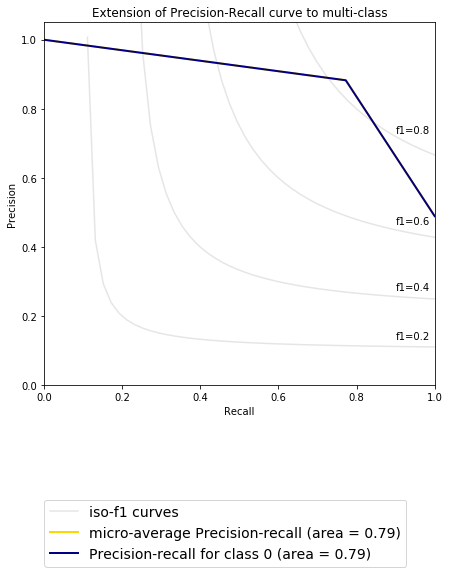

In [18]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Use label_binarize to be multi-label like settings
Y = label_binarize(y_test, classes=[0, 1])
Y_p = label_binarize(preds, classes=[0, 1])
n_classes = Y.shape[1]

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y[:, i], Y_p[:, i])
    average_precision[i] = average_precision_score(Y[:, i], Y_p[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y.ravel(), Y_p.ravel())
average_precision["micro"] = average_precision_score(Y, Y_p, average="micro")

# Plot
from itertools import cycle
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    a = np.linspace(0.01, 1)
    b = f_score * a / (2 * a - f_score)
    l, = plt.plot(a[b >= 0], b[b >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, b[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.5), prop=dict(size=14))
plt.show()

#### Feature Importance

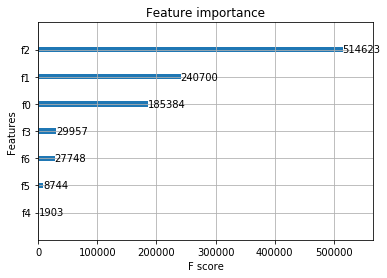

In [17]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(bst)
plt.show()